In [55]:
# Import Dependencies
import requests
import pandas as pd  
from sqlalchemy import create_engine
from config import remote_db_endpoint, remote_db_port
from config import remote_db_name, remote_db_user, remote_db_pwd
import numpy as np
from sqlalchemy import func
from sqlalchemy import distinct
import json
import psycopg2
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [56]:
cloud_engine = create_engine(f"postgresql://{remote_db_user}:{remote_db_pwd}@{remote_db_endpoint}:{remote_db_port}/{remote_db_name}")
cloud_conn = cloud_engine.connect()

ca_school_data = pd.read_sql('select * from ml_master_clean', cloud_conn)

ca_school_data.head()

,Zipcode,Total Students Enrolled,Median Household Income,Median Income BLACK/AA,Median Income INDIGENOUS PEOPLE,Median Income ASIAN,Median Income HAW/PAC ISLANDER,Median Income OTHER RACE,Median Income MIXED RACE,Median Income WHITE/NOT LATINO,...,Substance Abuse Count,Violent Count,Miscellaneous Count,School Name,School Rating,School Address,City,Grades,Students Per Teacher,District
0,91901,244.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,...,317.0,50.0,52.0,The Heights Charter,7.0,"2710 Alpine Boulevard, Suite E",Alpine,K-8,15:1,Dehesa Elementary
1,91901,333.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,...,317.0,50.0,52.0,Boulder Oaks Elementary,6.0,2320 Tavern Road,Alpine,1-5,24:1,Alpine Union Elementary
2,91901,438.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,...,317.0,50.0,52.0,Joan MacQueen Middle,6.0,2001 Tavern Road,Alpine,6-8,20:1,Alpine Union Elementary
3,91901,387.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,...,317.0,50.0,52.0,Shadow Hills Elementary,6.0,8770 Harbison Canyon Road,Alpine,K-5,20:1,Alpine Union Elementary
4,91901,158.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,...,317.0,50.0,52.0,Alpine Elementary,4.0,1850 Alpine Boulevard,Alpine,1-5,20:1,Alpine Union Elementary


Four New Columns for Crime ratios are created which will standardize the count with the Zipcode population
The new columns created are 'Theft Count Ratio', 'Substance Abuse Count Ratio', 'Violent Count Ratio' and 'Miscellaneous Count Ratio'

In [57]:
ca_school_data['Theft Count Ratio'] = ca_school_data['Theft Count'] / ca_school_data['Population Total']
ca_school_data['Substance Abuse Count Ratio'] = ca_school_data['Substance Abuse Count'] / ca_school_data['Population Total']
ca_school_data['Violent Count Ratio'] = ca_school_data['Violent Count'] / ca_school_data['Population Total']
ca_school_data['Miscellaneous Count Ratio'] = ca_school_data['Miscellaneous Count'] / ca_school_data['Population Total']
ca_school_data.head(75)

,Zipcode,Total Students Enrolled,Median Household Income,Median Income BLACK/AA,Median Income INDIGENOUS PEOPLE,Median Income ASIAN,Median Income HAW/PAC ISLANDER,Median Income OTHER RACE,Median Income MIXED RACE,Median Income WHITE/NOT LATINO,...,School Rating,School Address,City,Grades,Students Per Teacher,District,Theft Count Ratio,Substance Abuse Count Ratio,Violent Count Ratio,Miscellaneous Count Ratio
0,91901,244.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,...,7.0,"2710 Alpine Boulevard, Suite E",Alpine,K-8,15:1,Dehesa Elementary,0.004269,0.017129,0.002702,0.002810
1,91901,333.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,...,6.0,2320 Tavern Road,Alpine,1-5,24:1,Alpine Union Elementary,0.004269,0.017129,0.002702,0.002810
2,91901,438.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,...,6.0,2001 Tavern Road,Alpine,6-8,20:1,Alpine Union Elementary,0.004269,0.017129,0.002702,0.002810
3,91901,387.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,...,6.0,8770 Harbison Canyon Road,Alpine,K-5,20:1,Alpine Union Elementary,0.004269,0.017129,0.002702,0.002810
4,91901,158.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,...,4.0,1850 Alpine Boulevard,Alpine,1-5,20:1,Alpine Union Elementary,0.004269,0.017129,0.002702,0.002810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,91915,332.0,101760.0,109750.0,0.0,101328.0,0.0,82159.0,121719.0,117525.0,...,4.0,1949 Discovery Falls Drive,Chula Vista,6-8,14:1,SBC - High Tech High,0.003226,0.000319,0.001489,0.002340
71,91916,211.0,69821.0,0.0,0.0,0.0,0.0,0.0,0.0,69955.0,...,6.0,24842 Viejas Boulevard,Descanso,K-6,21:1,Mountain Empire Unified,0.002483,0.000000,0.000000,0.000000
72,91932,896.0,46659.0,40521.0,74773.0,41701.0,0.0,37527.0,36649.0,57344.0,...,6.0,650 Imperial Beach Boulevard,Imperial Beach,K-8,20:1,South Bay Union,0.004632,0.006402,0.004406,0.003126
73,91932,1585.0,46659.0,40521.0,74773.0,41701.0,0.0,37527.0,36649.0,57344.0,...,4.0,505 Elm Avenue,Imperial Beach,9-12,25:1,Sweetwater Union High,0.004632,0.006402,0.004406,0.003126


Removing the Crime Actual Counts from the dataframe i.e. 
1. Theft Count
2. Substance Abuse Count
3. Violent Count
4. Miscellaneous Count

In [58]:
ca_school_data = ca_school_data.drop(labels=["Theft Count", "Substance Abuse Count","Violent Count","Miscellaneous Count"], axis=1)
ca_school_data.head(75)

,Zipcode,Total Students Enrolled,Median Household Income,Median Income BLACK/AA,Median Income INDIGENOUS PEOPLE,Median Income ASIAN,Median Income HAW/PAC ISLANDER,Median Income OTHER RACE,Median Income MIXED RACE,Median Income WHITE/NOT LATINO,...,School Rating,School Address,City,Grades,Students Per Teacher,District,Theft Count Ratio,Substance Abuse Count Ratio,Violent Count Ratio,Miscellaneous Count Ratio
0,91901,244.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,...,7.0,"2710 Alpine Boulevard, Suite E",Alpine,K-8,15:1,Dehesa Elementary,0.004269,0.017129,0.002702,0.002810
1,91901,333.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,...,6.0,2320 Tavern Road,Alpine,1-5,24:1,Alpine Union Elementary,0.004269,0.017129,0.002702,0.002810
2,91901,438.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,...,6.0,2001 Tavern Road,Alpine,6-8,20:1,Alpine Union Elementary,0.004269,0.017129,0.002702,0.002810
3,91901,387.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,...,6.0,8770 Harbison Canyon Road,Alpine,K-5,20:1,Alpine Union Elementary,0.004269,0.017129,0.002702,0.002810
4,91901,158.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,...,4.0,1850 Alpine Boulevard,Alpine,1-5,20:1,Alpine Union Elementary,0.004269,0.017129,0.002702,0.002810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,91915,332.0,101760.0,109750.0,0.0,101328.0,0.0,82159.0,121719.0,117525.0,...,4.0,1949 Discovery Falls Drive,Chula Vista,6-8,14:1,SBC - High Tech High,0.003226,0.000319,0.001489,0.002340
71,91916,211.0,69821.0,0.0,0.0,0.0,0.0,0.0,0.0,69955.0,...,6.0,24842 Viejas Boulevard,Descanso,K-6,21:1,Mountain Empire Unified,0.002483,0.000000,0.000000,0.000000
72,91932,896.0,46659.0,40521.0,74773.0,41701.0,0.0,37527.0,36649.0,57344.0,...,6.0,650 Imperial Beach Boulevard,Imperial Beach,K-8,20:1,South Bay Union,0.004632,0.006402,0.004406,0.003126
73,91932,1585.0,46659.0,40521.0,74773.0,41701.0,0.0,37527.0,36649.0,57344.0,...,4.0,505 Elm Avenue,Imperial Beach,9-12,25:1,Sweetwater Union High,0.004632,0.006402,0.004406,0.003126


Removing the following columns from the dataframe i.e. 
1. latitude
2. longitude
3. School Address
4. City
5. Grades


In [59]:
ca_school_drop = ca_school_data.drop(labels=["latitude", "longitude","School Name", "Grades","School Address","City",
                                             'Zipcode', 'Students Per Teacher', 'District'], axis=1)
ca_school_drop.head(75)

,Total Students Enrolled,Median Household Income,Median Income BLACK/AA,Median Income INDIGENOUS PEOPLE,Median Income ASIAN,Median Income HAW/PAC ISLANDER,Median Income OTHER RACE,Median Income MIXED RACE,Median Income WHITE/NOT LATINO,Median Income HISPANIC/LATINO,...,Population asian ratio,Population haw/pac islander ratio,Population other ratio,Population mixed ratio,Population hispanic/latino ratio,School Rating,Theft Count Ratio,Substance Abuse Count Ratio,Violent Count Ratio,Miscellaneous Count Ratio
0,244.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,49500.0,...,0.011023,0.001297,0.006754,0.012212,0.168153,7.0,0.004269,0.017129,0.002702,0.002810
1,333.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,49500.0,...,0.011023,0.001297,0.006754,0.012212,0.168153,6.0,0.004269,0.017129,0.002702,0.002810
2,438.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,49500.0,...,0.011023,0.001297,0.006754,0.012212,0.168153,6.0,0.004269,0.017129,0.002702,0.002810
3,387.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,49500.0,...,0.011023,0.001297,0.006754,0.012212,0.168153,6.0,0.004269,0.017129,0.002702,0.002810
4,158.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,49500.0,...,0.011023,0.001297,0.006754,0.012212,0.168153,4.0,0.004269,0.017129,0.002702,0.002810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,332.0,101760.0,109750.0,0.0,101328.0,0.0,82159.0,121719.0,117525.0,89612.0,...,0.208302,0.000000,0.010777,0.033961,0.472544,4.0,0.003226,0.000319,0.001489,0.002340
71,211.0,69821.0,0.0,0.0,0.0,0.0,0.0,0.0,69955.0,0.0,...,0.014277,0.004345,0.000000,0.015518,0.120422,6.0,0.002483,0.000000,0.000000,0.000000
72,896.0,46659.0,40521.0,74773.0,41701.0,0.0,37527.0,36649.0,57344.0,41723.0,...,0.082282,0.008887,0.000226,0.039578,0.500998,6.0,0.004632,0.006402,0.004406,0.003126
73,1585.0,46659.0,40521.0,74773.0,41701.0,0.0,37527.0,36649.0,57344.0,41723.0,...,0.082282,0.008887,0.000226,0.039578,0.500998,4.0,0.004632,0.006402,0.004406,0.003126


In [60]:
ca_school_updated = ca_school_drop
ca_school_updated

,Total Students Enrolled,Median Household Income,Median Income BLACK/AA,Median Income INDIGENOUS PEOPLE,Median Income ASIAN,Median Income HAW/PAC ISLANDER,Median Income OTHER RACE,Median Income MIXED RACE,Median Income WHITE/NOT LATINO,Median Income HISPANIC/LATINO,...,Population asian ratio,Population haw/pac islander ratio,Population other ratio,Population mixed ratio,Population hispanic/latino ratio,School Rating,Theft Count Ratio,Substance Abuse Count Ratio,Violent Count Ratio,Miscellaneous Count Ratio
0,244.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,49500.0,...,0.011023,0.001297,0.006754,0.012212,0.168153,7.0,0.004269,0.017129,0.002702,0.00281
1,333.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,49500.0,...,0.011023,0.001297,0.006754,0.012212,0.168153,6.0,0.004269,0.017129,0.002702,0.00281
2,438.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,49500.0,...,0.011023,0.001297,0.006754,0.012212,0.168153,6.0,0.004269,0.017129,0.002702,0.00281
3,387.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,49500.0,...,0.011023,0.001297,0.006754,0.012212,0.168153,6.0,0.004269,0.017129,0.002702,0.00281
4,158.0,79859.0,143917.0,53750.0,78625.0,0.0,48026.0,0.0,88039.0,49500.0,...,0.011023,0.001297,0.006754,0.012212,0.168153,4.0,0.004269,0.017129,0.002702,0.00281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,422.0,77829.0,0.0,0.0,92614.0,0.0,56964.0,103520.0,80927.0,67027.0,...,0.030981,0.000594,0.000764,0.025181,0.227365,9.0,0.000000,0.000057,0.000000,0.00000
692,575.0,77829.0,0.0,0.0,92614.0,0.0,56964.0,103520.0,80927.0,67027.0,...,0.030981,0.000594,0.000764,0.025181,0.227365,7.0,0.000000,0.000057,0.000000,0.00000
693,929.0,77829.0,0.0,0.0,92614.0,0.0,56964.0,103520.0,80927.0,67027.0,...,0.030981,0.000594,0.000764,0.025181,0.227365,7.0,0.000000,0.000057,0.000000,0.00000
694,889.0,77829.0,0.0,0.0,92614.0,0.0,56964.0,103520.0,80927.0,67027.0,...,0.030981,0.000594,0.000764,0.025181,0.227365,5.0,0.000000,0.000057,0.000000,0.00000


In [61]:
ca_school_updated.to_csv('sd_schools_tableau2.csv',index=False)

In [62]:
# Using OneHotEncoder to create the features
# Generate our categorical variable lists
ca_school_cat = list(ca_school_updated.dtypes[ca_school_updated.dtypes == "object"].index)
ca_school_cat

[]

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split our preprocessed data into our features and target arrays
X = ca_school_updated.drop("School Rating", axis=1).values
y = ca_school_updated["School Rating"].values.reshape(-1, 1)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)
y_train = y_train.flatten()
y_test = y_test.flatten()

In [64]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

k: 1, Train/Test Score: 0.998/0.259
k: 3, Train/Test Score: 0.546/0.207
k: 5, Train/Test Score: 0.504/0.241
k: 7, Train/Test Score: 0.410/0.270
k: 9, Train/Test Score: 0.402/0.236
k: 11, Train/Test Score: 0.395/0.241
k: 13, Train/Test Score: 0.393/0.241
k: 15, Train/Test Score: 0.375/0.247
k: 17, Train/Test Score: 0.354/0.253
k: 19, Train/Test Score: 0.345/0.241


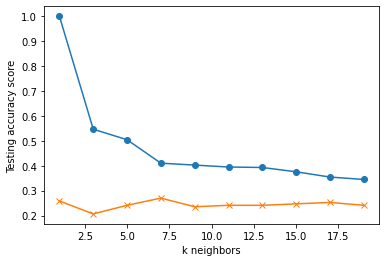

In [65]:
# Loop through different k values to find which has the highest accuracy.
# Note: We use only odd numbers because we don't want any ties.
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy score")
plt.show()

In [69]:
# Note that k: 11 seems to be the best choice for this dataset
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_scaled, y_train)
print('k=11 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))

k=11 Test Acc: 0.270


In [67]:
y_true = y_test
y_pred = knn.predict(X_test_scaled)

y_true = y_true.astype(np.int)
print(y_true)
y_true
df = pd.DataFrame({'true':y_true.flatten(),'pred':y_pred.flatten()})
df


[ 9  4  4  8  7  8  8  4  6  4  3  6  8  4  3  2  7  1  4  5  6  9  7  8
  4  3  5  5  8 10  5  7  8  9  8  4  3  5  8  6  6  6  4  5  7  4  9  6
  5  3  9  6  9  4  3  8  3  5  3  8  8  6  6  4  9  5  6  5  7  4  8  5
  7  5  6  3  9  2  8  6  3  8  4  8  8  7  2  6  5  2  5  6  7  7  9  9
  4  6  7  3  9  3  9  8  3  7  3 10  5  3  4  7  3  4  4  3  8  2  7  2
 10 10  8  2  6  6  7  6  5  6  6  5  2  7  8  1  8  9  5  8  4  6  6  4
  8  4  4  5  9  8  5  6  5  7  7  2  9  7  3  6  9  6  4  8  4  7  9  7
  8  3  3  4  6  3]


,true,pred
0,9,9.0
1,4,5.0
2,4,4.0
3,8,8.0
4,7,9.0
...,...,...
169,3,6.0
170,3,4.0
171,4,4.0
172,6,5.0


In [68]:
df['MSE'] = (df['pred']-df['true'])**2
df['SD'] = np.sqrt((df['MSE']))
df.describe()

,true,pred,MSE,SD
count,174.000000,174.000000,174.000000,174.000000
mean,5.781609,5.413793,4.390805,1.574713
std,2.205748,1.871920,6.532013,1.386410
min,1.000000,2.000000,0.000000,0.000000
25%,4.000000,4.000000,1.000000,1.000000
50%,6.000000,5.000000,1.000000,1.000000
75%,8.000000,7.000000,4.000000,2.000000
max,10.000000,9.000000,36.000000,6.000000
